# Switching Linear Dynamical Systems (SLDS) Demo

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lindermanlab/ssm-jax-refactor/blob/main/notebooks/gaussian-slds-example.ipynb)

_Switching Linear Dynamical Systems_ (SLDS) provide a natural way of combining Linear Dynamical Systems with Hidden Markov Models. They allow us to approximate a system that has globally non-linear dynamics by a series linear systems. A good reference for these types of systems is ["Variational Inference for State Space models"](https://www.cs.toronto.edu/~hinton/absps/switch.pdf) by Ghahramani and Hinton. 

An SLDS comprises $K$ discrete hidden states, which evolve according to a Markov chain. We'll call the hidden state $z$, and use the notation $z_t = k$ to mean that the system is in state $k$ at time $t$. The Markov chain for the hidden state is specified by a state-transition matrix $P$, where $P_{ij} = P(z_t = j \mid z_{t-1} = i)$.

### Generative Model for SLDS
The generative model for an SLDS combines an HMM with a set of linear dynamical systems as follows. In addition to the discrete state, we have a continuous latent state $x_t \in \mathbb{R}^D$ and an observation $y_t \in \mathbb{R}^N$. Each discrete state $\{1,\ldots,K
\}$ is associated with a different dynamics matrix $A_k$ and a different measurement matrix $C_k$. Formally, we generate data from an SLDS as follows:

1. **Discrete State Update**. At each time step, sample a new discrete state $z_t \mid z_{t-1}$ with probabilities given by a Markov chain.

2. **Continuous State Update**. Update the state using the dynamics matrix corresponding to the new discrete state:
$$
x_t \sim \mathcal{N}(A_k x_{t-1} + B_k u_{t} + b_k, Q_k)
$$
$A_k$ is the dynamics matrix corresponding to discrete state $k$. $u_t$ is the input vector (specified by the user, not inferred by SSM) and $B_k$ is the corresponding control matrix. The vector $b$ is a bias vector, which can drive the dynamics in a particular direction. 
The matrix $Q_k$ specifies the covariance of the Gaussian noise added at time step $t$, which perturbs the dynamics. 

3. **Emission**. We now make an observation of the state, according to the specified observation model. In the general case, the state controlls the observation via a generalized linear model:
$$
y_t \sim \mathcal{P}(\eta(C_k x_t + D_k u_t d_t))
$$
$\mathcal{P}$ is a probabibility distribution. The inner arguments form an affine measurement of the state, which is then passed through the mean function $\eta(\cdot)$ to obtain the expected value of the emission, $\mathbb{E}[y_t \mid x_t]$.
In this case, $C_k$ is the measurement matrix corresponding to discrete state $k$, $D_k$ is called the feedthrough matrix or passthrough matrix (it passes the input directly to the emission), and $d_k$ is a bias term corresponding to discrete state $k$. In the Gaussian case, the emission can simply be written as $y_t \sim \mathcal{N}(C_k x_t D_k u_t + d_k, R_k)$ where $R_k$ is the covariance of the Gaussian noise. 
  



# 1. Setup

We import `jax` and `ssm`, as well as some plotting utils.

In [1]:
import jax.numpy as np
import jax.random as jr

from ssm.utils import random_rotation
from ssm.slds.models import GaussianSLDS
from ssm.plots import gradient_cmap

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple"
]


colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

# 2. Creating an SLDS and sampling from it

In [2]:
# First, specify hyperparameters
num_states = 5
latent_dim = 2
data_dim = 10
num_timesteps = 10000

## Set the initial state probabilities

In [3]:
initial_state_probs = np.ones(num_states) / num_states
initial_state_mean = np.zeros((latent_dim))
initial_state_scale_tril = np.eye(latent_dim)

## Make a transition matrix

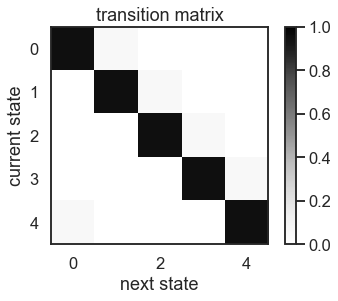

In [4]:
transition_probs = (np.arange(num_states)**10).astype(float)
transition_probs /= transition_probs.sum()
transition_matrix = np.zeros((num_states, num_states))
for k, p in enumerate(transition_probs[::-1]):
    transition_matrix += np.roll(p * np.eye(num_states), k, axis=1)
    
plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
plt.xlabel("next state")
plt.ylabel("current state")
plt.title("transition matrix")
plt.colorbar()

## Make simple linear dynamics for each state.

These dynamics rotate and converge to a fixed point at a specified location around the unit circle.

We call these **starfish dynamics** for reasons that will become obvious in a second.

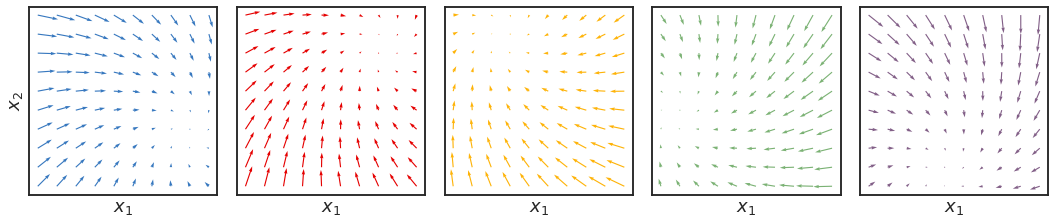

In [5]:
keys = jr.split(jr.PRNGKey(0), num_states)
theta = np.pi / 25 # rotational frequency
angles = np.linspace(0, 2 * np.pi, num_states, endpoint=False)
biases = np.column_stack([np.cos(angles), np.sin(angles), np.zeros((num_states, latent_dim - 2))])
dynamics_weights = np.array([0.8 * random_rotation(key, latent_dim, theta=theta) for key in keys])
dynamics_biases = np.column_stack([np.cos(angles), np.sin(angles), np.zeros((num_states, latent_dim - 2))])
dynamics_scale_trils = np.tile(np.sqrt(0.001) * np.eye(latent_dim), (num_states, 1, 1))

# Plot the dynamics
if latent_dim == 2:
    lim = 5
    x = np.linspace(-lim, lim, 10)
    y = np.linspace(-lim, lim, 10)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    fig, axs = plt.subplots(1, num_states, figsize=(3 * num_states, 6))
    for k in range(num_states):
        A, b = dynamics_weights[k], dynamics_biases[k]
        dxydt_m = xy.dot(A.T) + b - xy
        axs[k].quiver(xy[:, 0], xy[:, 1],
                    dxydt_m[:, 0], dxydt_m[:, 1],
                    color=colors[k % len(colors)])

        
        axs[k].set_xlabel('$x_1$')
        axs[k].set_xticks([])
        if k == 0:
            axs[k].set_ylabel("$x_2$")
        axs[k].set_yticks([])
        axs[k].set_aspect("equal")
                        

    plt.tight_layout()

## Set the emissions parameters

In this model, the emissions weights and biases will be the same for all discrete states.

In [6]:
emissions_weights = np.tile(jr.normal(jr.PRNGKey(1), (data_dim, latent_dim)), (num_states, 1, 1))
emissions_biases = np.zeros((num_states, data_dim))
emissions_scale_trils = np.tile(0.1 * np.eye(data_dim), (num_states, 1, 1))

## Construct the Gaussian SLDS

In [7]:
slds = GaussianSLDS(num_states,
                    latent_dim,
                    data_dim,
                    initial_state_probs,
                    initial_state_mean,
                    initial_state_scale_tril,
                    transition_matrix,
                    dynamics_weights,
                    dynamics_biases,
                    dynamics_scale_trils,
                    emissions_weights,
                    emissions_biases,
                    emissions_scale_trils)

## Sample data from the SLDS.

Note that the states that come out are a dictionary with `continuous` and `discrete` keys.

In [8]:
true_states, data = slds.sample(jr.PRNGKey(3), num_timesteps)
true_x = true_states["continuous"]
true_z = true_states["discrete"]


## Plot the latent states

We plot the continuous latent state trajectory $x_1, \ldots, x_T$, color-coded by the corresponding discrete state $z_t$. See why we call these starfish dynamics?

Text(0, 0.5, '$x_2$')

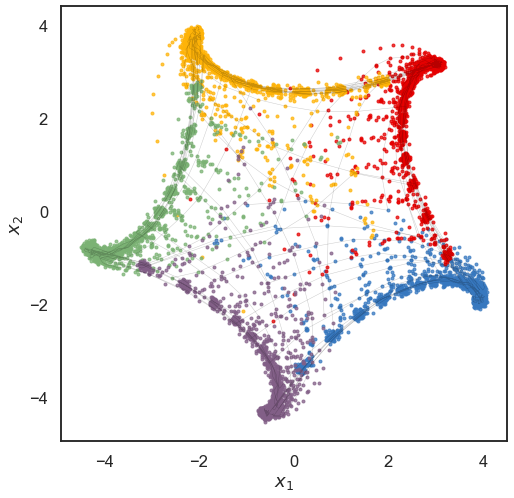

In [9]:
fig = plt.figure(figsize=(8, 8))
for k in range(num_states):
    plt.plot(*true_x[true_z==k].T, 'o', color=colors[k],
         alpha=0.75, markersize=3)
    
plt.plot(*true_x[:1000].T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

## Plot the data

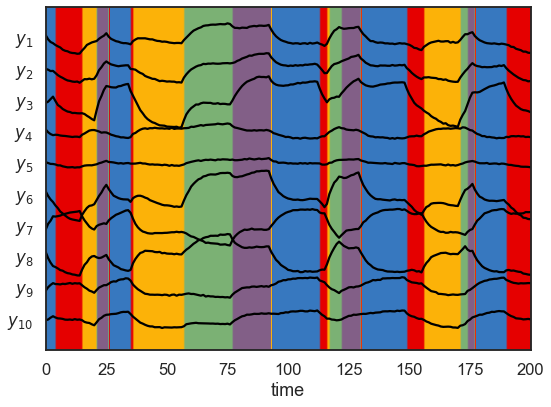

In [10]:
plot_slice = (0, 200)
lim = 1.05 * abs(data).max()
plt.figure(figsize=(8, 6))
plt.imshow(true_z[None, :],
           aspect="auto",
           cmap=cmap,
           vmin=0,
           vmax=len(colors)-1,
           extent=(0, num_timesteps, -(data_dim)*lim, lim))


for d in range(data_dim):
    plt.plot(data[:,d] - lim * d, '-k')

plt.xlim(plot_slice)
plt.xlabel("time")
plt.yticks(-lim * np.arange(data_dim), ["$y_{{{}}}$".format(d+1) for d in range(data_dim)])

plt.tight_layout()


## Evaluate the joint log probability under the model

In [11]:
slds.log_probability(true_states, data) / num_timesteps

DeviceArray(12.681138, dtype=float32)

# 3. Fit an SLDS from the observed data

First make another `GaussianSLDS` object. Since we're fitting this one to data, we'll use a simpler constructor that just randomly initializes the parameters. All we have to do is give it the hyperparameters (number of discrete states, continuous state dimension, and the emission dimension) and a random number generator key.

In [12]:
test_slds = GaussianSLDS(num_states, latent_dim, data_dim, key=jr.PRNGKey(1))

## Fit the model!

We fit SLDS models with variational EM. This algorithm alternates between:

1. **Variational E step:** Approximate the posterior distribution over latent states by minimizing the Kullback-Leibler (KL) divergence to the true posterior,
\begin{align}
q(z, x) &= \arg \min_{\mathcal{Q}} D_{\mathrm{KL}}\left(q(z, x) \,\|\, p(z, x \mid y, \theta) \right)
\end{align}
We use a _structured mean field_ approximation, which takes the variational family $\mathcal{Q}$ to be
\begin{align}
\mathcal{Q} &= \left\{ q(z, x): q(z, x) = q(z_{1:T}) q(x_{1:T}) \right\}
\end{align}
For Gaussian SLDS, we can find a local minimizer of the KL divergence via coordinate descent.

2. **M-step:** Find parameters that maximize the _expected log probability_:
\begin{align}
\theta^\star &= \arg \max_\theta \mathbb{E}_{q(z,x)}\left[\log p(z, x, y \mid \theta)\right]
\end{align}

At each step of the algorithm, we compute the **evidence lower bound** or ELBO,
\begin{align}
\mathcal{L}(q, \theta) &= \mathbb{E}_{q(z,x)} \left[\log p(z, x, y \mid \theta) - \log q(z, x) \right],
\end{align}
which tracks the progress of the variational EM algorithm. This bound can be computed analytically for the Gaussian SLDS, but it is simpler to just compute a Monte Carlo approximation, 
\begin{align}
\hat{\mathcal{L}}(q, \theta) &= \frac{1}{S} \sum_{s=1}^S \left[\log p(z^{(s)}, x^{(s)}, y \mid \theta) - \log q(z^{(s)}, x^{(s)}) \right], \\
\text{where} \quad z^{(s)}, x^{(s)} &\sim q(z, x).
\end{align}
If all goes well, this bound should increase and plateau throughout the fitting procedure.

In the code below, we also use a **callback** to track the inferred discrete states over the iterations of the algorithm.

In [13]:
def callback(model, posterior):
    # Get the discrete posterior for the first (and only) batch
    q_z = posterior.discrete_posterior.expected_states[0]
    return np.argmax(q_z, axis=-1)

bounds, model, posterior, segmentations = \
    test_slds.fit(jr.PRNGKey(0), data, callback=callback)

  0%|          | 0/100 [00:00<?, ?it/s]

## Plot the bound over iterations
The ELBOs should increase over the course of fitting

Text(0, 0.5, 'elbo')

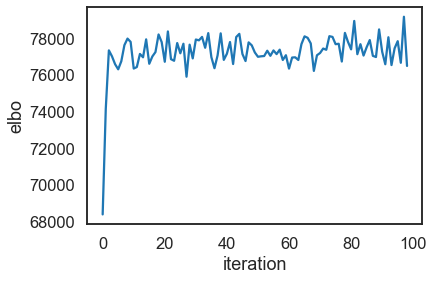

In [14]:
plt.plot(bounds[1:])
plt.xlabel("iteration")
plt.ylabel("elbo")

## Plot the inferred discrete states over iterations

Over the first few iterations, the states should change a fair amount.  Then they should stabilize.

Text(0, 0.5, 'vEM iteration')

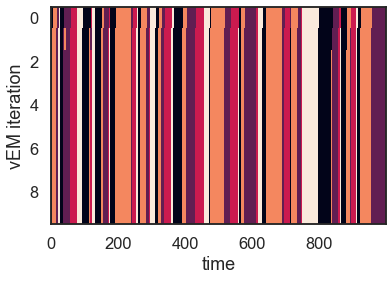

In [15]:
plt.figure(figsize=(6, 4))
plt.imshow(np.array(segmentations)[:10, :1000], aspect="auto", interpolation="none")
plt.xlabel("time")
plt.ylabel("vEM iteration")

## Compare the true and inferred discrete states

Text(0.5, 1.0, 'inferred state probabilities')

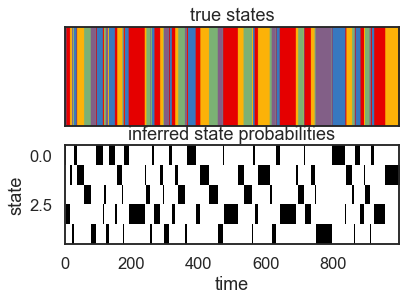

In [16]:
inferred_discrete_states = posterior.discrete_posterior.expected_states[0]

# Get the most likely discrete states
# NOTE: Should use the Viterbi algorithm instead!
most_likely_discrete_states = np.argmax(inferred_discrete_states, axis=-1)

fig, axs = plt.subplots(2,1,sharex=True)
axs[0].imshow(true_states["discrete"][None, :1000], aspect="auto", cmap=cmap)
axs[0].set_yticks([])
axs[0].set_title("true states")

axs[1].imshow(inferred_discrete_states[:1000, :].T, aspect="auto", cmap="Greys", interpolation="none")
axs[1].set_ylabel("state")
axs[1].set_xlabel("time")
axs[1].set_title("inferred state probabilities")

## Plot the inferred continuous states

Hopefully we recovered the starfish dynamics of the latent states.

_Note: the SLDS latent states are invariant to invertible linear transformations, so the scale of the inferred states should not necessarily match that of the true latent states._

Text(0, 0.5, '$x_2$')

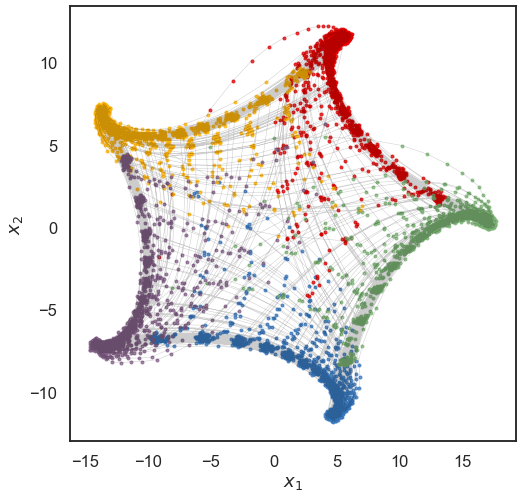

In [17]:
inferred_continuous_states = posterior.continuous_posterior.expected_states[0]

fig = plt.figure(figsize=(8, 8))
for k in range(num_states):
    plt.plot(*inferred_continuous_states[most_likely_discrete_states==k].T, 
             'o', color=colors[k], alpha=0.75, markersize=3)
    
plt.plot(*inferred_continuous_states.T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")